In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cst
from scipy.optimize import fsolve, root_scalar
from scipy import linalg
from numpy import sin, cos, sqrt, pi
import copy

from qnlmodels.snail import Snail

In [2]:
# Constants
e0 = 8.854e-12 #F / m
kB = 1.380649e-23 # Boltzmann const
hbar = 1.054571817e-34
h = 6.62607015e-34
q = 1.602176634e-19
e = q
phi0 = h / 2 / q

In [3]:
class dispersion_in_JJ_metamaterial:
# Class Declaration (Adapted from https://github.com/arpitranadive/JJ_metamaterial_simulation/blob/master/dispersion_and_gain_in_TWPAs.py)

	def __init__(self):

		self.version = '0.1.1'

		self.pump_frequency = None				# in GHz
		self.incident_pump_amplitude = None		
		self.phi_ext = np.pi 					# external magnetic flux in the loop		

		self.loss_tangent = None				# loss tangent
		self.number_of_loops = None				# number of loops in the transmission line
		self.size_of_one_loop = None			# size of one SNAIL loop in m
		self.I0 = None							# critical current of large junction
		self.I0_ratio = None					# ratio of critical currents in the SNAIL
		self.C_g = None							# ground capacitance
		self.C_J = None							# junction capacitance

		self.gamma = None						# kerr nonlinearity
		self.L_loop = None						# loop inductance
		self.noise = None

		self.phi_0 = h / (2 * e)



	def linear_to_dB(self,linear):

		return 10*(np.log10(linear))


	def I(self,phi_s):

		return self.I0_ratio*self.I0*np.sin(phi_s)+self.I0*np.sin((phi_s-self.phi_ext)/3.0)


	def calculate_loop_parameters(self):

		phi_smin = fsolve(self.I, 0)
		gamma_tilde = (1.0/6)*(self.I0_ratio*np.cos(phi_smin)+(1.0/27)*np.cos((phi_smin-self.phi_ext)/3.0))
		alpha_tilde = self.I0_ratio*np.cos(phi_smin)+(1.0/3)*np.cos((phi_smin-self.phi_ext)/3.0)
		self.gamma = gamma_tilde/alpha_tilde
		self.L_loop = abs(1.0*self.phi_0/(alpha_tilde*self.I0*2*np.pi))


	def phase_mismatch(self,w_s):

		pump_frequency = self.pump_frequency
		pump_amplitude = self.incident_pump_amplitude
		loss_tangent = self.loss_tangent
		gamma = self.gamma
		L_loop = self.L_loop
		C_g = self.C_g
		C_J = self.C_J

		w_p = pump_frequency*1e9*2*np.pi
		w_i = 2*w_p-w_s
		w_0 = 1.0/(np.sqrt(L_loop*C_g))
		w_J = 1.0/(np.sqrt(L_loop*C_J))
		k_p = w_p/(w_0*np.sqrt(1-(w_p/w_J)**2))
		k_s = w_s/(w_0*np.sqrt(1-(w_s/w_J)**2))
		k_i = w_i/(w_0*np.sqrt(1-(w_i/w_J)**2))
		w_til_p = 1-(w_p/w_J)**2
		w_til_s = 1-(w_s/w_J)**2
		w_til_i = 1-(w_i/w_J)**2
		k_p_loss = loss_tangent*k_p/2
		pump_amplitude_reduced = pump_amplitude*np.exp(-k_p_loss*self.number_of_loops/2)
		eta_p = 3*gamma*(k_p**3)*(pump_amplitude_reduced**2)/(8*w_til_p)
		eta_s = 3*gamma*2*(k_p**2)*k_s*(pump_amplitude_reduced**2)/(8*w_til_s)
		eta_i = 3*gamma*2*(k_p**2)*k_i*(pump_amplitude_reduced**2)/(8*w_til_i)
		del_k_disp = 2*k_p-k_i-k_s
		del_kerr = 2*eta_p-eta_i-eta_s
		del_k_total = del_k_disp + del_kerr
		return del_k_disp, del_kerr, del_k_total


	def phase_mismatch_vs_frequency(self,freq_array):
		
		del_k_disp_array = np.array([])
		del_k_kerr_array = np.array([])
		del_k_total_array = np.array([])

		for freq in freq_array:

			del_k_disp, del_kerr, del_k_total = self.phase_mismatch(freq*1e9*2*np.pi)
			del_k_disp_array = np.append(del_k_disp_array,del_k_disp)
			del_k_kerr_array = np.append(del_k_kerr_array,del_kerr)
			del_k_total_array = np.append(del_k_total_array,del_k_total)

		return del_k_disp_array/self.size_of_one_loop, del_k_kerr_array/self.size_of_one_loop, del_k_total_array/self.size_of_one_loop


	def gain(self,w_s):

		pump_frequency = self.pump_frequency
		pump_amplitude = self.incident_pump_amplitude
		loss_tangent = self.loss_tangent
		gamma = self.gamma
		L_loop = self.L_loop
		C_g = self.C_g
		C_J = self.C_J
		number_of_loops = self.number_of_loops

		w_p = pump_frequency*1e9*2*np.pi
		w_i = 2*w_p-w_s
		w_0 = 1.0/(np.sqrt(L_loop*C_g))
		w_J = 1.0/(np.sqrt(L_loop*C_J))
		k_p = w_p/(w_0*np.sqrt(1-(w_p/w_J)**2))
		k_s = w_s/(w_0*np.sqrt(1-(w_s/w_J)**2))
		k_i = w_i/(w_0*np.sqrt(1-(w_i/w_J)**2))
		w_til_p = 1-(w_p/w_J)**2
		w_til_s = 1-(w_s/w_J)**2
		w_til_i = 1-(w_i/w_J)**2
		k_p_loss = loss_tangent*k_p/2
		pump_amplitude_reduced = pump_amplitude*np.exp(-k_p_loss*number_of_loops/2)
		eta_p = 3*gamma*(k_p**3)*(pump_amplitude_reduced**2)/(8*w_til_p)
		eta_s = 3*gamma*2*(k_p**2)*k_s*(pump_amplitude_reduced**2)/(8*w_til_s)
		eta_i = 3*gamma*2*(k_p**2)*k_i*(pump_amplitude_reduced**2)/(8*w_til_i)
		del_k_disp = 2*k_p-k_i-k_s
		del_kerr = 2*eta_p-eta_i-eta_s
		del_k_total = del_k_disp + del_kerr

		k_i_loss = loss_tangent*k_i/2
		k_s_loss = loss_tangent*k_s/2
		Phi11 = -1j*0.5*del_k_total-k_s_loss
		Phi12 = 1j*eta_s*k_i/(k_s*2)
		Phi21 = -1j*eta_i*k_s/(k_i*2)
		Phi22 = 1j*0.5*del_k_total-k_i_loss
		matrix_Phi = np.array([[Phi11[0],Phi12[0]],[Phi21[0],Phi22[0]]])
		
		exp_Phi = linalg.expm(matrix_Phi*number_of_loops)

		if self.noise:
			exp_Phi[0][0] += np.sqrt(complex(k_s_loss))/2/np.pi
			exp_Phi[1][1] += np.sqrt(complex(k_i_loss))/2/np.pi
		
		gain_lin = abs(exp_Phi[0][0])**2

		return self.linear_to_dB(gain_lin)
	
	def gain_for_Cg_range(self, w_s, Cg_values):

		if len(Cg_values) != self.number_of_loops: return "Each cell must have a capacitance value, but there are {:.0f} cells and {:.0f} capacitances".format(self.number_of_loops, len(Cg_values))
		
		pump_frequency = self.pump_frequency
		pump_amplitude = self.incident_pump_amplitude
		loss_tangent = self.loss_tangent
		C_J = self.C_J
		gamma = self.gamma
		L_loop = self.L_loop

		w_p = pump_frequency*1e9*2*np.pi
		w_i = 2*w_p-w_s
		w_J = 1.0/(np.sqrt(L_loop*C_J))
		w_til_p = 1-(w_p/w_J)**2
		w_til_s = 1-(w_s/w_J)**2
		w_til_i = 1-(w_i/w_J)**2

		pump_amplitude_reduced = pump_amplitude

		for Cg in Cg_values:
			# self.C_g = Cg
			
			w_0 = 1.0/(np.sqrt(L_loop*Cg))
			
			k_p = w_p/(w_0*np.sqrt(1-(w_p/w_J)**2))
			k_s = w_s/(w_0*np.sqrt(1-(w_s/w_J)**2))
			k_i = w_i/(w_0*np.sqrt(1-(w_i/w_J)**2))

			k_p_loss = loss_tangent*k_p/2

			pump_amplitude_reduced = pump_amplitude_reduced*np.exp(-k_p_loss/2)
		net_matrix_Phi = np.zeros((2,2))
		
		for Cg in Cg_values:
			# self.C_g = Cg

			w_0 = 1.0/(np.sqrt(L_loop*Cg))

			k_p = w_p/(w_0*np.sqrt(1-(w_p/w_J)**2))
			k_s = w_s/(w_0*np.sqrt(1-(w_s/w_J)**2))
			k_i = w_i/(w_0*np.sqrt(1-(w_i/w_J)**2))

			k_p_loss = loss_tangent*k_p/2

			eta_p = 3*gamma*(k_p**3)*(pump_amplitude_reduced**2)/(8*w_til_p)
			eta_s = 3*gamma*2*(k_p**2)*k_s*(pump_amplitude_reduced**2)/(8*w_til_s)
			eta_i = 3*gamma*2*(k_p**2)*k_i*(pump_amplitude_reduced**2)/(8*w_til_i)
			
			del_k_disp = 2*k_p-k_i-k_s
			del_kerr = 2*eta_p-eta_i-eta_s
			del_k_total = del_k_disp + del_kerr

			k_i_loss = loss_tangent*k_i/2
			k_s_loss = loss_tangent*k_s/2
			Phi11 = -1j*0.5*del_k_total-k_s_loss
			Phi12 = 1j*eta_s*k_i/(k_s*2)
			Phi21 = -1j*eta_i*k_s/(k_i*2)
			Phi22 = 1j*0.5*del_k_total-k_i_loss
			matrix_Phi = np.array([[Phi11[0],Phi12[0]],[Phi21[0],Phi22[0]]])
			net_matrix_Phi = np.add(net_matrix_Phi,matrix_Phi)
		
		exp_Phi = linalg.expm(net_matrix_Phi)

		if self.noise:
			exp_Phi[0][0] += np.sqrt(complex(k_s_loss))/2/np.pi
			exp_Phi[1][1] += np.sqrt(complex(k_i_loss))/2/np.pi
		
		gain_lin = abs(exp_Phi[0][0])**2

		return self.linear_to_dB(gain_lin)
	
	def gain_for_ratio_range(self, w_s, r_values):

		if len(r_values) != self.number_of_loops: return "Each cell must have a ratio value, but there are {:.0f} cells and {:.0f} ratios".format(self.number_of_loops, len(r_values))
		
		pump_frequency = self.pump_frequency
		pump_amplitude = self.incident_pump_amplitude
		loss_tangent = self.loss_tangent
		C_J = self.C_J
		Cg = self.C_g

		pump_amplitude_reduced = pump_amplitude
		
		for r in r_values:

			self.I0_ratio = r
			self.calculate_loop_parameters()
			gamma = self.gamma
			L_loop = self.L_loop

			w_p = pump_frequency*1e9*2*np.pi
			w_i = 2*w_p-w_s
			w_J = 1.0/(np.sqrt(L_loop*C_J))
			w_til_p = 1-(w_p/w_J)**2
			w_til_s = 1-(w_s/w_J)**2
			w_til_i = 1-(w_i/w_J)**2
			
			w_0 = 1.0/(np.sqrt(L_loop*Cg))
			
			k_p = w_p/(w_0*np.sqrt(1-(w_p/w_J)**2))
			k_s = w_s/(w_0*np.sqrt(1-(w_s/w_J)**2))
			k_i = w_i/(w_0*np.sqrt(1-(w_i/w_J)**2))

			k_p_loss = loss_tangent*k_p/2

			pump_amplitude_reduced = pump_amplitude_reduced*np.exp(-k_p_loss/2)

		net_matrix_Phi = np.zeros((2,2))
		
		for r in r_values:
			
			self.I0_ratio = r
			self.calculate_loop_parameters()
			gamma = self.gamma
			L_loop = self.L_loop

			w_p = pump_frequency*1e9*2*np.pi
			w_i = 2*w_p-w_s
			w_J = 1.0/(np.sqrt(L_loop*C_J))
			w_til_p = 1-(w_p/w_J)**2
			w_til_s = 1-(w_s/w_J)**2
			w_til_i = 1-(w_i/w_J)**2

			w_0 = 1.0/(np.sqrt(L_loop*Cg))

			k_p = w_p/(w_0*np.sqrt(1-(w_p/w_J)**2))
			k_s = w_s/(w_0*np.sqrt(1-(w_s/w_J)**2))
			k_i = w_i/(w_0*np.sqrt(1-(w_i/w_J)**2))

			k_p_loss = loss_tangent*k_p/2

			eta_p = 3*gamma*(k_p**3)*(pump_amplitude_reduced**2)/(8*w_til_p)
			eta_s = 3*gamma*2*(k_p**2)*k_s*(pump_amplitude_reduced**2)/(8*w_til_s)
			eta_i = 3*gamma*2*(k_p**2)*k_i*(pump_amplitude_reduced**2)/(8*w_til_i)
			
			del_k_disp = 2*k_p-k_i-k_s
			del_kerr = 2*eta_p-eta_i-eta_s
			del_k_total = del_k_disp + del_kerr

			k_i_loss = loss_tangent*k_i/2
			k_s_loss = loss_tangent*k_s/2
			Phi11 = -1j*0.5*del_k_total-k_s_loss
			Phi12 = 1j*eta_s*k_i/(k_s*2)
			Phi21 = -1j*eta_i*k_s/(k_i*2)
			Phi22 = 1j*0.5*del_k_total-k_i_loss
			matrix_Phi = np.array([[Phi11[0],Phi12[0]],[Phi21[0],Phi22[0]]])
			net_matrix_Phi = np.add(net_matrix_Phi,matrix_Phi)
		
		exp_Phi = linalg.expm(net_matrix_Phi)

		if self.noise:
			exp_Phi[0][0] += np.sqrt(complex(k_s_loss))/2/np.pi
			exp_Phi[1][1] += np.sqrt(complex(k_i_loss))/2/np.pi
		
		gain_lin = abs(exp_Phi[0][0])**2

		return self.linear_to_dB(gain_lin)


	def gain_vs_freq(self,freq_array):
		
		gain_array = np.array([])

		for freq_s in freq_array:

			w_s = freq_s*1e9*2*np.pi
			gain_array = np.append(gain_array,self.gain(w_s))

		return gain_array

	# Custom Plotting Functions

	def gain_vs_ground_cap(self, cap_array, w_s):
		
		gain_array = np.array([])
		w_s = w_s*1e9*2*np.pi

		for Cg in cap_array:
			self.I0_ratio = Cg
			self.calculate_loop_parameters()
			gain_array = np.append(gain_array,self.gain(w_s))

		return gain_array

	def plot_g4_vs_flux(self, flux_range):
		g4s = []
		for flux_ratio in flux_range:
			self.phi_ext = 2*np.pi*flux_ratio
			self.calculate_loop_parameters()
			g4s.append(self.gamma * q**2 / 4 / self.C_g / hbar * 1e-6) #MHz

		plt.figure(figsize=(8, 6))
		plt.plot(flux_range, g4s)
		plt.xlabel('Quantized Flux')
		plt.ylabel('g4 (MHz)')
		plt.grid(True)
		plt.show()

In [4]:
### Final TWPA parameters ###

J0 = 1.2e-6
junction_area = 0.85 * 2

I0 = J0 * junction_area

sim_params = {
    'pump_frequency': 10, #GHz
    'incident_pump_amplitude': 1.82,
    'loss_tangent': 1e-5,
    'number_of_loops': 688,
    'size_of_one_loop': 1, #m
    'I0': I0, #A
    'I0_ratio': 0.08, 
    'C_g': 255e-15, #F
    'C_J': 70e-15 #F
}

for key, value in sim_params.items():
    print(key, value)

def gain_stats (low_freq, high_freq, freq_values, gain_values):
    freq_indices = np.where(np.logical_and(freq_values>=low_freq, freq_values<=high_freq))
    gain_per_frequency = [] 
    for i in freq_indices[0]:
        gain_per_frequency+=[gain_values[i]]
    return np.sum(gain_per_frequency), np.sum(gain_per_frequency)/len(gain_per_frequency), np.max(gain_per_frequency)

pump_frequency 10
incident_pump_amplitude 1.82
loss_tangent 1e-05
number_of_loops 688
size_of_one_loop 1
I0 2.04e-06
I0_ratio 0.08
C_g 2.55e-13
C_J 7e-14


Range = 6.00 to 8.00 GHz
Max gain = 167.1 at 6.76 GHz
Avg gain = 155.7
GBP = 31149.9
L = 636.815 pH
Z0 = 49.973 Ohms
w0 = 78.474 GHz
wj = 149.777 GHz
Init Reflection Coefficient = -0.0002688


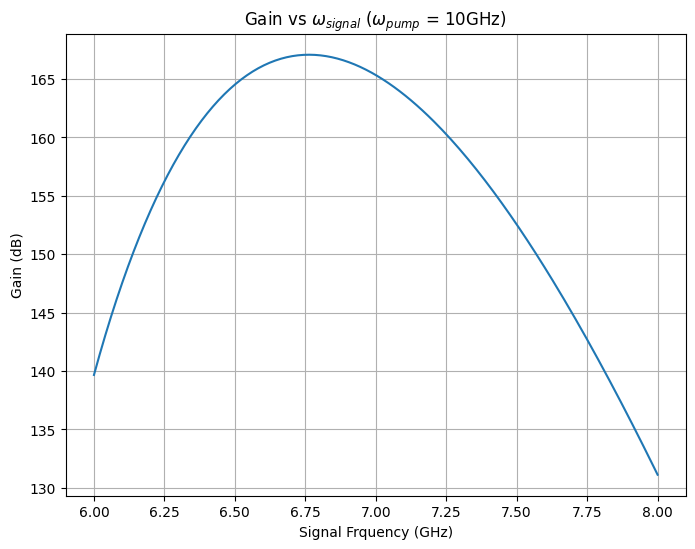

In [5]:
### Gain simulation and parameter space plots ###
# Create a copy of sim with original parameters
sim_original = copy.deepcopy(dispersion_in_JJ_metamaterial())

for key, value in sim_params.items():
    setattr(sim_original, key, value)
sim_original.calculate_loop_parameters()

low_freq = 6
high_freq = 8

omega_s_range = np.linspace(low_freq, high_freq, 200)

gain_values = sim_original.gain_vs_freq(omega_s_range)

GBP, avg_gain, max_gain = gain_stats(low_freq, high_freq, omega_s_range, gain_values)

print("Range = {:.2f} to {:.2f} GHz".format(low_freq, high_freq))
print("Max gain = {:.1f} at {:.2f} GHz".format(max_gain, omega_s_range[np.where(gain_values==np.max(gain_values))[0][0]]))
print("Avg gain = {:.1f}".format(avg_gain))
print("GBP = {:.1f}".format(GBP))

print("L = {:.3f} pH".format(sim_original.L_loop[0]*1e12))
print("Z0 = {:.3f} Ohms".format(np.sqrt(sim_original.L_loop[0]/sim_original.C_g)))
print("w0 = {:.3f} GHz".format(1e-9/np.sqrt(sim_original.L_loop[0]*sim_original.C_g)))
print("wj = {:.3f} GHz".format(1e-9/np.sqrt(sim_original.L_loop[0]*sim_original.C_J)))
print("Init Reflection Coefficient = {:.7f}".format((np.sqrt(sim_original.L_loop[0]/sim_original.C_g)-50)/(np.sqrt(sim_original.L_loop[0]/sim_original.C_g)+50)))

plt.figure(figsize=(8, 6))
plt.plot(omega_s_range, gain_values)
plt.xlabel('Signal Frquency (GHz)')
plt.ylabel(r'Gain (dB)')
plt.title(r'Gain vs $\omega_{signal}$ ($\omega_{pump}$ = 10GHz)')
plt.grid(True)
plt.show()

Range = 6.00 to 8.00 GHz
Max gain = 108.3 at 7.25 GHz
Avg gain = 87.8
GBP = 17551.1
L = 636.815 pH
Z0 = 49.973 Ohms
w0 = 78.474 GHz
wj = 149.777 GHz
Init Reflection Coefficient = -0.0002688


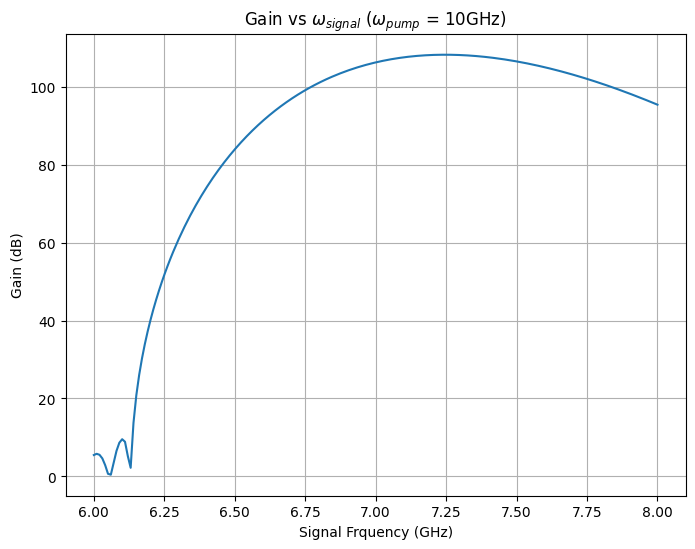

In [6]:
### Gain simulation with varying ground capacitance and parameter space plots ###
# Create a copy of sim with original parameters
sim_copy_Cg = copy.deepcopy(sim_original)

C_g_values = np.linspace(0.5*sim_params['C_g'], sim_params['C_g'], sim_original.number_of_loops)

gain_values = [sim_copy_Cg.gain_for_Cg_range(ws*1e9*2*np.pi, C_g_values) for ws in omega_s_range]

GBP, avg_gain, max_gain = gain_stats(low_freq, high_freq, omega_s_range, gain_values)

print("Range = {:.2f} to {:.2f} GHz".format(low_freq, high_freq))
print("Max gain = {:.1f} at {:.2f} GHz".format(max_gain, omega_s_range[np.where(gain_values==np.max(gain_values))[0][0]]))
print("Avg gain = {:.1f}".format(avg_gain))
print("GBP = {:.1f}".format(GBP))

print("L = {:.3f} pH".format(sim_copy_Cg.L_loop[0]*1e12))
print("Z0 = {:.3f} Ohms".format(np.sqrt(sim_copy_Cg.L_loop[0]/sim_copy_Cg.C_g)))
print("w0 = {:.3f} GHz".format(1e-9/np.sqrt(sim_copy_Cg.L_loop[0]*sim_copy_Cg.C_g)))
print("wj = {:.3f} GHz".format(1e-9/np.sqrt(sim_copy_Cg.L_loop[0]*sim_copy_Cg.C_J)))
print("Init Reflection Coefficient = {:.7f}".format((np.sqrt(sim_copy_Cg.L_loop[0]/sim_copy_Cg.C_g)-50)/(np.sqrt(sim_copy_Cg.L_loop[0]/sim_copy_Cg.C_g)+50)))

plt.figure(figsize=(8, 6))
plt.plot(omega_s_range, gain_values)
plt.xlabel('Signal Frquency (GHz)')
plt.ylabel(r'Gain (dB)')
plt.title(r'Gain vs $\omega_{signal}$ ($\omega_{pump}$ = 10GHz)')
plt.grid(True)
plt.show()

Range = 6.00 to 8.00 GHz
Max gain = 184.9 at 6.55 GHz
Avg gain = 171.4
GBP = 34276.9
L = 635.934 pH
Z0 = 49.939 Ohms
w0 = 78.528 GHz
wj = 149.880 GHz
Init Reflection Coefficient = -0.0006149


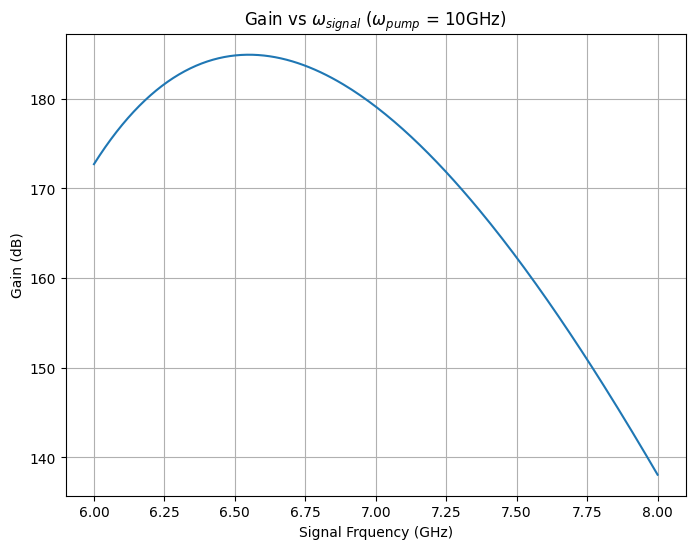

In [7]:
### Gain simulation with varying ground capacitance and parameter space plots ###
# Create a copy of sim with original parameters
sim_copy_r = copy.deepcopy(sim_original)

r_range = np.random.normal(loc=sim_original.I0_ratio, scale=0.2*sim_original.I0_ratio, size=sim_original.number_of_loops)

gain_values = [sim_copy_r.gain_for_ratio_range(ws*1e9*2*np.pi, r_range) for ws in omega_s_range]

GBP, avg_gain, max_gain = gain_stats(low_freq, high_freq, omega_s_range, gain_values)

print("Range = {:.2f} to {:.2f} GHz".format(low_freq, high_freq))
print("Max gain = {:.1f} at {:.2f} GHz".format(max_gain, omega_s_range[np.where(gain_values==np.max(gain_values))[0][0]]))
print("Avg gain = {:.1f}".format(avg_gain))
print("GBP = {:.1f}".format(GBP))

print("L = {:.3f} pH".format(sim_copy_r.L_loop[0]*1e12))
print("Z0 = {:.3f} Ohms".format(np.sqrt(sim_copy_r.L_loop[0]/sim_copy_r.C_g)))
print("w0 = {:.3f} GHz".format(1e-9/np.sqrt(sim_copy_r.L_loop[0]*sim_copy_r.C_g)))
print("wj = {:.3f} GHz".format(1e-9/np.sqrt(sim_copy_r.L_loop[0]*sim_copy_r.C_J)))
print("Init Reflection Coefficient = {:.7f}".format((np.sqrt(sim_copy_r.L_loop[0]/sim_copy_r.C_g)-50)/(np.sqrt(sim_copy_r.L_loop[0]/sim_copy_r.C_g)+50)))

plt.figure(figsize=(8, 6))
plt.plot(omega_s_range, gain_values)
plt.xlabel('Signal Frquency (GHz)')
plt.ylabel(r'Gain (dB)')
plt.title(r'Gain vs $\omega_{signal}$ ($\omega_{pump}$ = 10GHz)')
plt.grid(True)
plt.show()

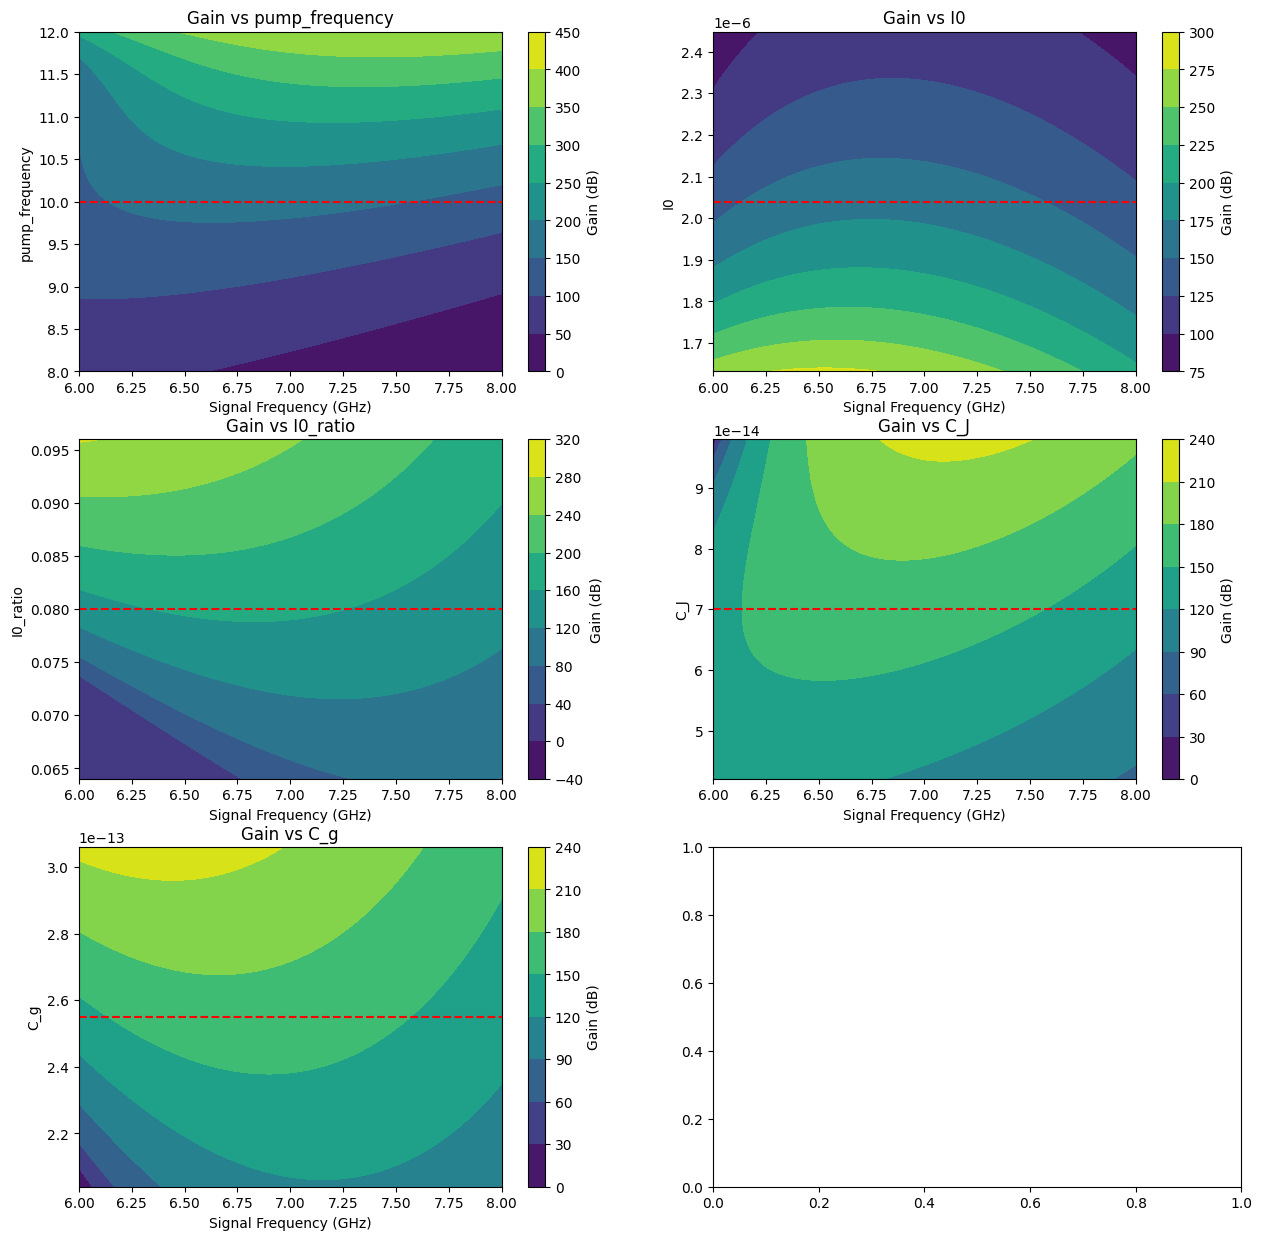

In [8]:
# Define the parameter ranges to explore
pump_frequencies = np.linspace(0.8*sim_params['pump_frequency'], 1.2*sim_params['pump_frequency'], 100)
number_of_loops_values = np.linspace(0.8*sim_params['number_of_loops'], 1.2*sim_params['number_of_loops'], 100)
I0_ratio_values = np.linspace(0.8*sim_params['I0_ratio'], 1.2*sim_params['I0_ratio'], 100)
I0_values = np.linspace(0.8*sim_params['I0'], 1.2*sim_params['I0'], 100)
C_J_values = np.linspace(0.6*sim_params['C_J'], 1.4*sim_params['C_J'], 100)
C_g_values = np.linspace(0.8*sim_params['C_g'], 1.2*sim_params['C_g'], 100)

# Create a subplot grid
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.2)

# Vary different parameters and plot gain maps
for ax, param_values, param_name in zip(axes.flatten(),
                                       [pump_frequencies, I0_values, I0_ratio_values, C_J_values, C_g_values],
                                       ['pump_frequency','I0', 'I0_ratio', 'C_J', 'C_g']):
    gains = []
    for param_value in param_values:
        # Create a copy of sim_original for each iteration
        sim_copy = copy.deepcopy(sim_original)

        # Set the parameter value in the simulation copy
        setattr(sim_copy, param_name, param_value)
        sim_copy.calculate_loop_parameters()  # Recalculate loop parameters if needed
        omega_s_range = np.linspace(6, 8, 100)
        gain_values = sim_copy.gain_vs_freq(omega_s_range)
        gains.append(gain_values)

    # Create a contour plot for the gain map
    X, Y = np.meshgrid(omega_s_range, param_values)
    gains = np.array(gains)
    contour = ax.contourf(X, Y, gains, cmap='viridis')
    ax.set_xlabel('Signal Frequency (GHz)')
    ax.set_ylabel(param_name)
    ax.set_title(f'Gain vs {param_name}')
    
    # Add horizontal line at value used in simulation
    ax.axhline(sim_params[param_name], color=(1,0,0), linestyle='--', label='Simulation Value')
    
    # Add colorbar legend
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label('Gain (dB)')

# Show the plots
plt.show()

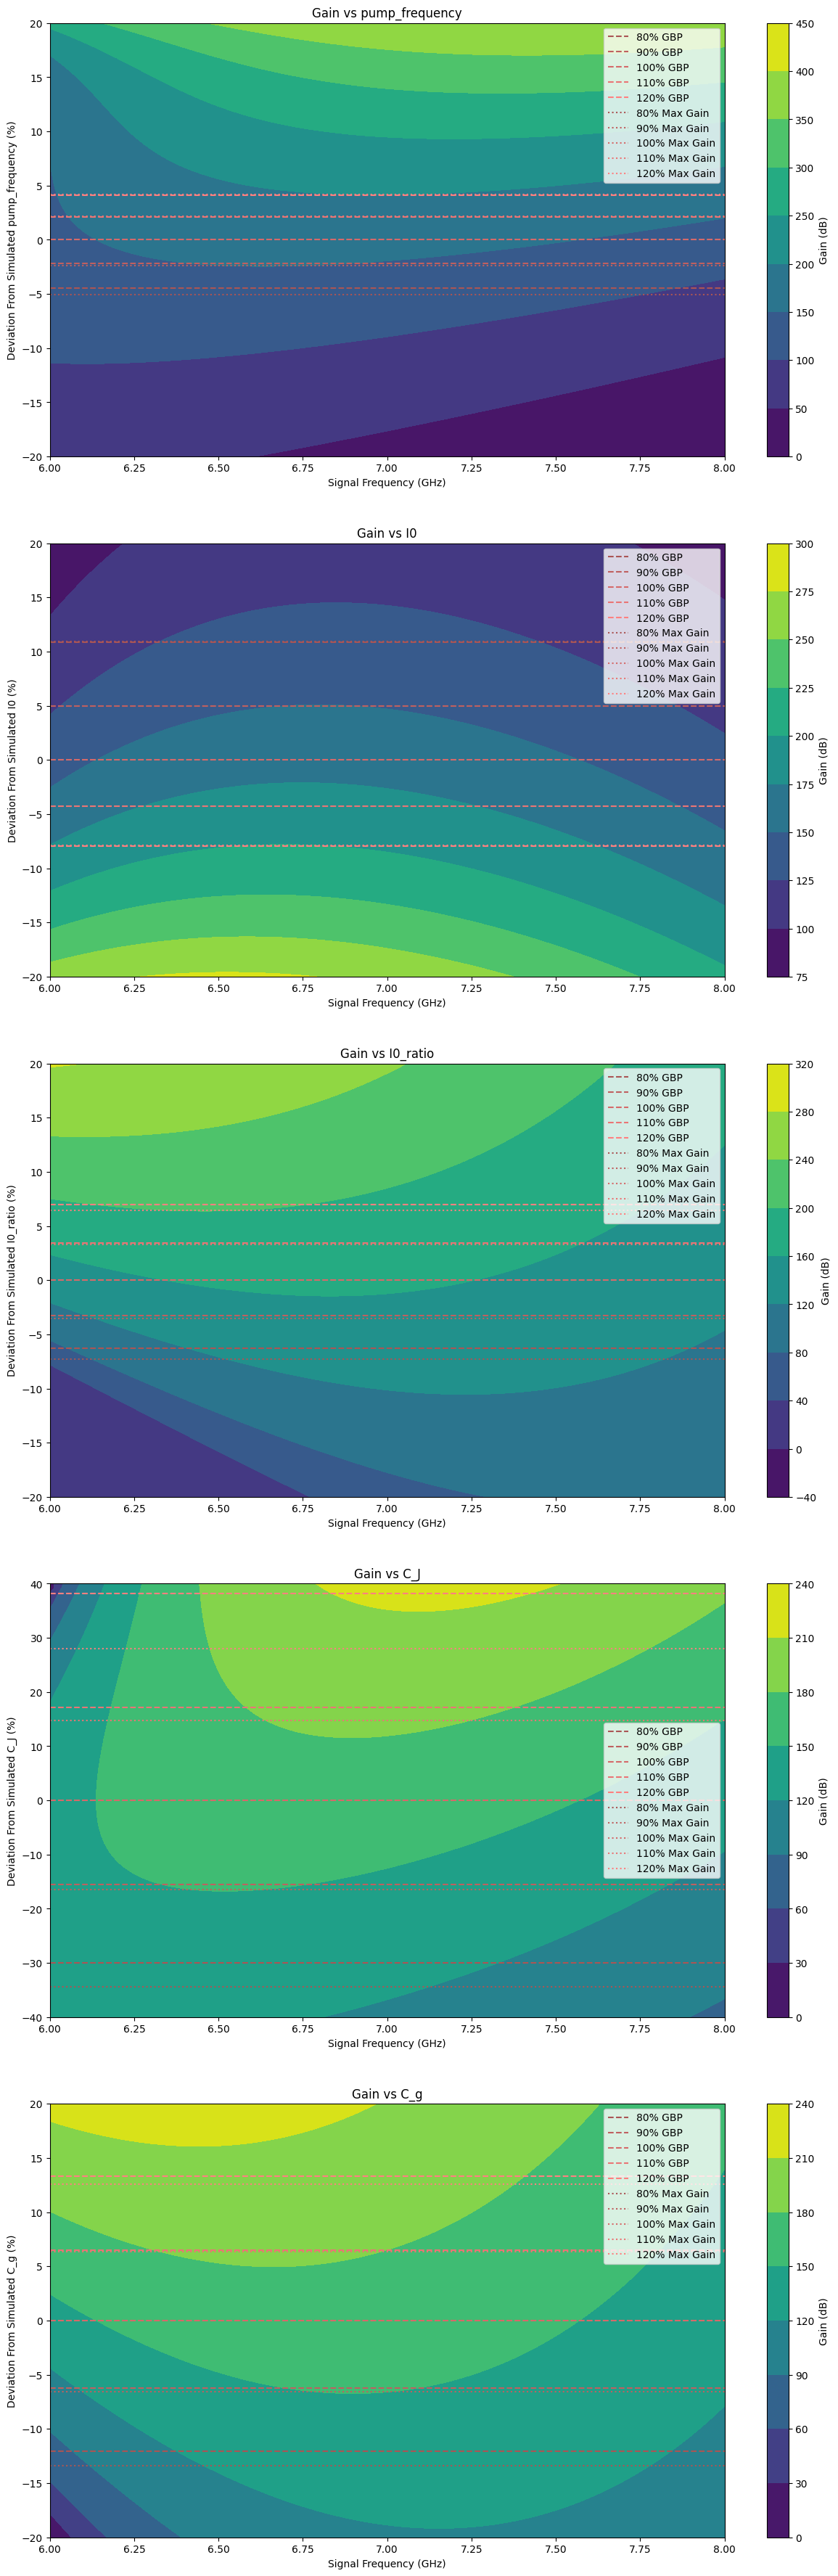

In [9]:
# Create a subplot grid
fig, axes = plt.subplots(5, 1, figsize=(15, 45))
fig.subplots_adjust(hspace=0.2)

#Define sensitivity as percent of parameter deviation required to change GBP by a given some amount
def gain_sensitivity_func (param_value, sim, freq_range, param_name, threshold, gain_stat_index=0):
    sim_copy = copy.deepcopy(sim)
    sim_copy.calculate_loop_parameters()
    gain_values_old_params = [sim_copy.gain(ws*np.pi*2e9) for ws in freq_range]

    setattr(sim_copy, param_name, param_value)
    sim_copy.calculate_loop_parameters()
    gain_values_new_params = [sim_copy.gain(ws*np.pi*2e9) for ws in freq_range]

    return (threshold)*gain_stats(freq_range[0], freq_range[-1], freq_range, gain_values_old_params)[gain_stat_index]/gain_stats(freq_range[0], freq_range[-1], freq_range, gain_values_new_params)[gain_stat_index] - 1

sens_thresholds = np.linspace(0.8, 1.2, 5)
gbp_sensitivities, avg_sensitivities, max_sensitivities = {}, {}, {}
omega_s_range = np.linspace(6, 8, 100)

# Vary different parameters and plot gain maps
for ax, param_values, param_name in zip(axes.flatten(),
                                       [pump_frequencies, I0_values, I0_ratio_values, C_J_values, C_g_values],
                                       ['pump_frequency','I0', 'I0_ratio', 'C_J', 'C_g']):
    gains, avg_gains = [], []
    gbp_sensitivities[param_name] = [round((fsolve(gain_sensitivity_func, 
                                            x0=getattr(sim_original, param_name),
                                            args=(sim_original, omega_s_range, param_name, th, 0))/getattr(sim_original, param_name) - 1)[0]*100,3) for th in sens_thresholds]
    max_sensitivities[param_name] = [round((fsolve(gain_sensitivity_func, 
                                            x0=getattr(sim_original, param_name),
                                            args=(sim_original, omega_s_range, param_name, th, 2))/getattr(sim_original, param_name) - 1)[0]*100,3) for th in sens_thresholds]
    for param_value in param_values:
        # Create a copy of sim_original for each iteration
        sim_copy = copy.deepcopy(sim_original)

        # Set the parameter value in the simulation copy
        setattr(sim_copy, param_name, param_value)
        sim_copy.calculate_loop_parameters()  # Recalculate loop parameters if needed
        gain_values = sim_copy.gain_vs_freq(omega_s_range)
        gains.append(gain_values)

    # Create a contour plot for the gain map
    X, Y = np.meshgrid(omega_s_range, [100*(param_value/sim_params[param_name]-1) for param_value in param_values])
    gains = np.array(gains)
    contour = ax.contourf(X, Y, gains, cmap='viridis')
    ax.set_xlabel('Signal Frequency (GHz)')
    ax.set_ylabel(f'Deviation From Simulated {param_name} (%)')
    ax.set_title(f'Gain vs {param_name}')

    for param_value, th in zip(gbp_sensitivities[param_name], sens_thresholds):
        ax.axhline(param_value, color=(th/sens_thresholds[-1], th/2/sens_thresholds[-1], th/2/sens_thresholds[-1]), linestyle='--', label=f'{int(th*100)}% GBP')

    for param_value, th in zip(max_sensitivities[param_name], sens_thresholds):
        ax.axhline(param_value, color=(th/sens_thresholds[-1], th/2/sens_thresholds[-1], th/2/sens_thresholds[-1]), linestyle=':', label=f'{int(th*100)}% Max Gain')

    ax.legend()
    # Add colorbar legend
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label('Gain (dB)')

# Show the plots
plt.show()

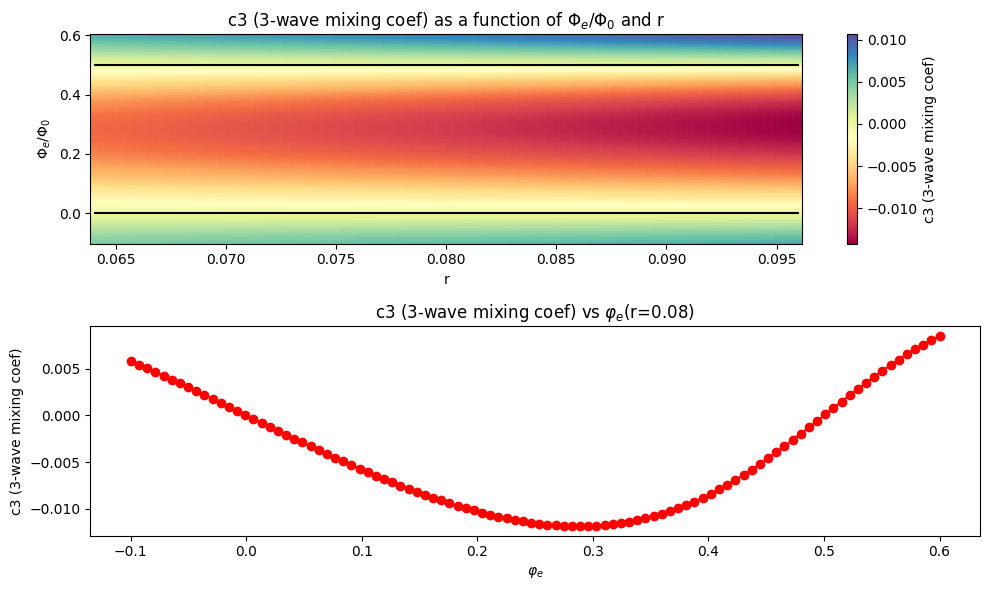

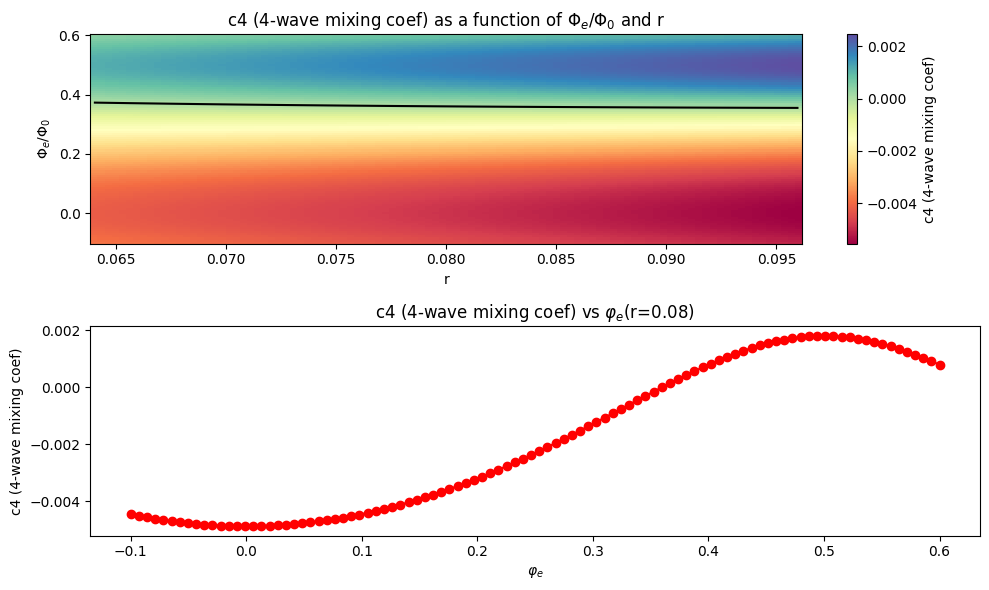

In [10]:
### SNAIL current simulation ###
snail = Snail(sim_params['C_g'], sim_params["I0"], 3)

# Define phi_e and r values
phis = np.linspace(-0.1, 0.6, 100)
rs = np.linspace(0.8*sim_params['I0_ratio'], 1.2*sim_params['I0_ratio'], 100)

# Plot heatmaps
snail.plot_heatmap(phis, rs, snail.c3, 'c3 (3-wave mixing coef)')

snail.plot_heatmap(phis, rs, snail.c4, 'c4 (4-wave mixing coef)')

In [ ]:
# UTILS

# Takes goal junction capacitance (F), outputs required seperation
def calc_JJ_distance(Cj):
    return e0 * 10 * (cell_layout.jj_height) * 1e-6 * (cell_layout.jj_width) * 1e-6 / Cj

print(f"JJ must have gap of {calc_JJ_distance(Cj)*1e9} nm")

JJ must have gap of 14.999999999999998 nm
